2025-06-10 13:10:43,516 | INFO    | ==========  STAGE 7: RISE-PROBABILITY EXPLORATION & DUAL LEADERBOARD COMPARISON ==========
2025-06-10 13:10:43,519 | INFO    | SWAN_YEAR=2008  RUN_DATE=20250609
2025-06-10 13:10:43,522 | INFO    | Exploring Domain-weighted predictions...
2025-06-10 13:10:43,731 | INFO    | Loaded Stage6_RISE_Predictions.csv (974 rows)

=== Metrics Ranked by Mean Predicted Resilience Probability (Domain-weighted) ===
                     Metric  Mean_Resilience_Prob
          OperatingCashFlow              0.893688
                GrossProfit              0.828350
               TotalRevenue              0.797342
                     EBITDA              0.759690
            OperatingIncome              0.751938
EarningBeforeInterestAndTax              0.735327
                       Cash              0.712071
                  NetIncome              0.705426
     CashAndCashEquivalents              0.684385
               FreeCashFlow              0.677741


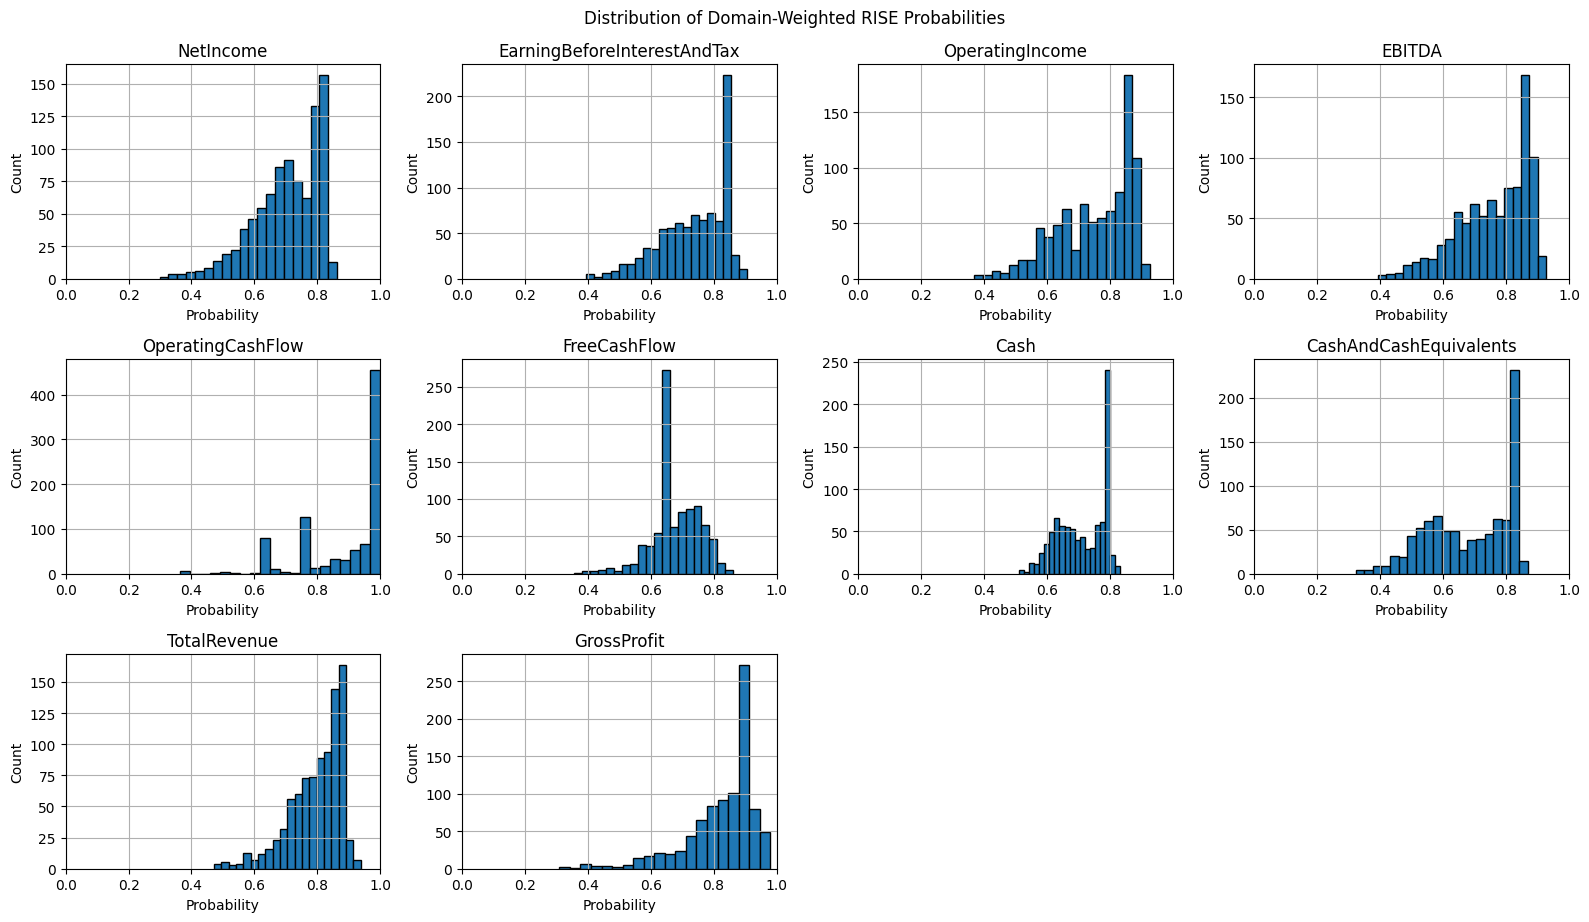

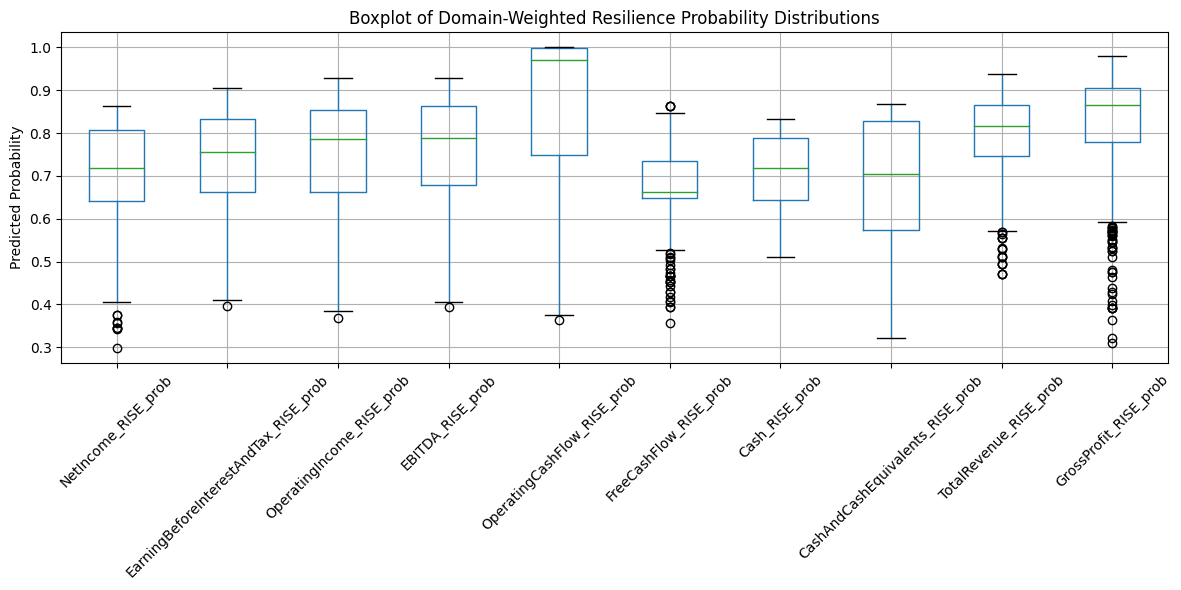

2025-06-10 13:10:45,861 | INFO    | Exploring Stage-weighted predictions...
2025-06-10 13:10:46,085 | INFO    | Loaded Stage6B_Stage_RISE_Predictions.csv (974 rows)

=== Metrics Ranked by Mean Predicted Resilience Probability (Stage-weighted) ===
                     Metric  Mean_Resilience_Prob
          OperatingCashFlow              0.899369
                GrossProfit              0.838648
               TotalRevenue              0.810820
                     EBITDA              0.725648
            OperatingIncome              0.718395
EarningBeforeInterestAndTax              0.703022
                       Cash              0.692611
                  NetIncome              0.675289
     CashAndCashEquivalents              0.664922
               FreeCashFlow              0.649601


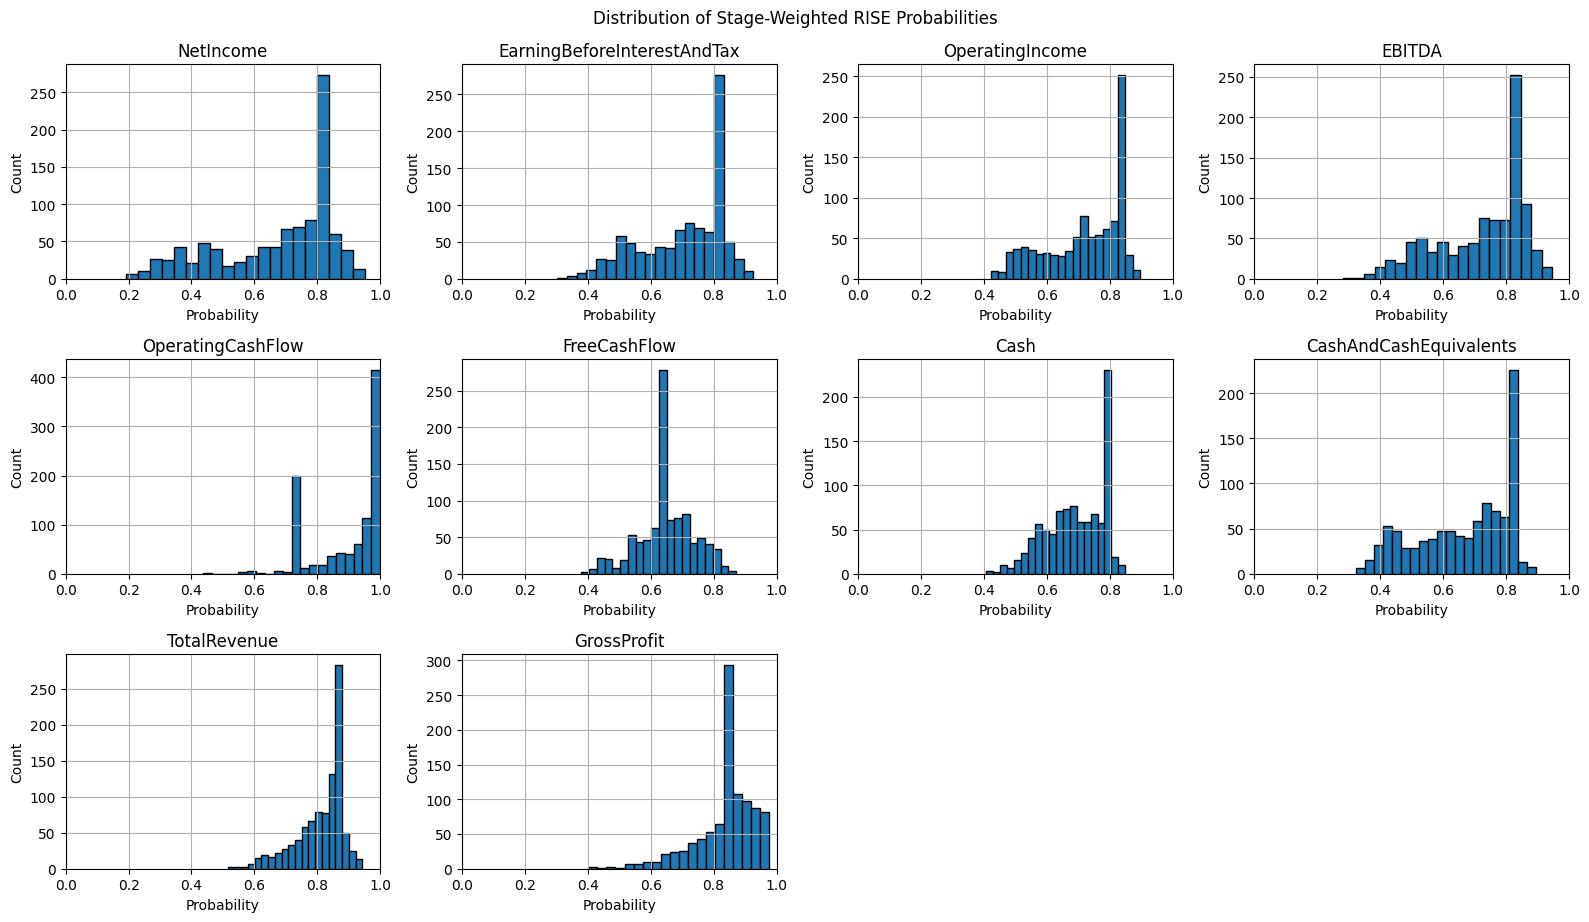

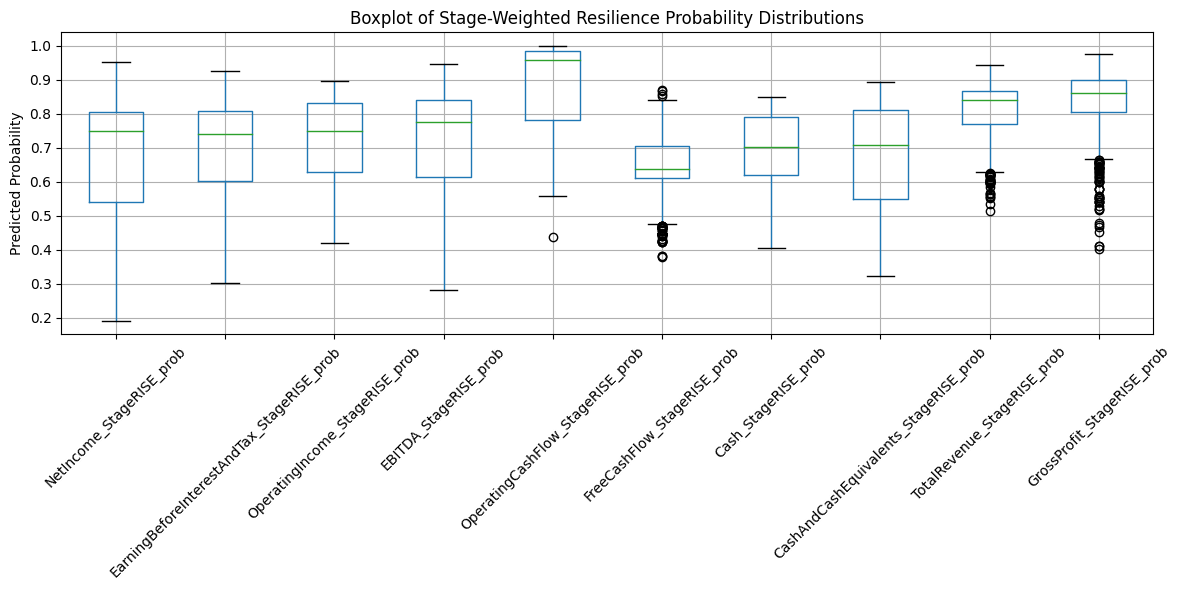

2025-06-10 13:10:48,652 | INFO    | Starting dual leaderboard comparison...
2025-06-10 13:10:48,657 | INFO    | ✓ Domain leaderboard written → Stage7C_Rank_Domain.csv
2025-06-10 13:10:48,662 | INFO    | ✓ Stage leaderboard written → Stage7C_Rank_Stage.csv
2025-06-10 13:10:48,680 | INFO    | ✓ Comparison table saved → Stage7C_Domain_vs_Stage_Comparison.csv

=== Domain vs. Stage – Mean Probability Gap ===
                     Metric  Mean_Resilience_Prob_Domain  Mean_Resilience_Prob_Stage      Diff
          OperatingCashFlow                     0.893688                    0.899369 -0.005682
                GrossProfit                     0.828350                    0.838648 -0.010298
               TotalRevenue                     0.797342                    0.810820 -0.013477
                     EBITDA                     0.759690                    0.725648  0.034042
            OperatingIncome                     0.751938                    0.718395  0.033543
EarningBeforeInterestAn

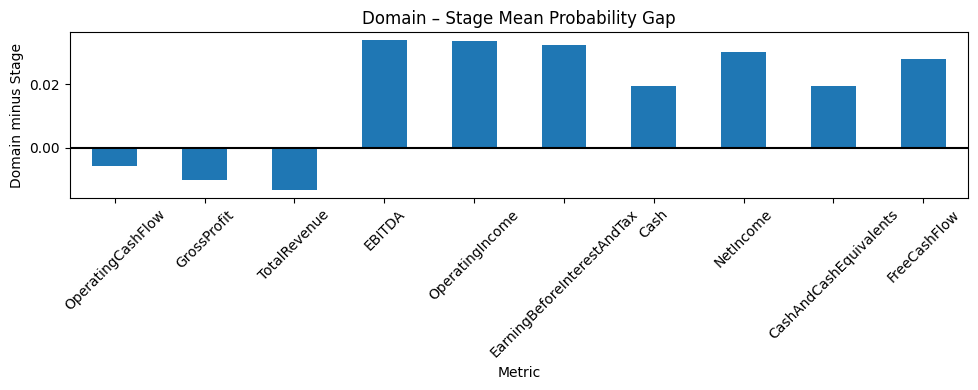

2025-06-10 13:10:48,862 | INFO    | ✅ Stage 7 complete – RISE-probability exploration and dual leaderboard comparison finished.


In [6]:
#!/usr/bin/env python
"""
STAGE 7 · RISE-PROBABILITY EXPLORATION & DUAL LEADERBOARD COMPARISON
────────────────────────────────────────────────────────────────────────────
This file performs the following:

A. RISE-Probability Exploration for Both Weighting Schemes:
   1. Loads domain-weighted predictions (Stage6_RISE_Predictions.csv) and 
      stage-weighted predictions (Stage6B_Stage_RISE_Predictions.csv) from the 
      stage06 folder.
   2. For each weighting, collects resilience probability columns,
      ranks metrics by mean predicted probability, and displays exploration
      charts (histogram grid and boxplot).

B. Dual Leaderboard Comparison:
   1. Ranks metrics by mean predicted resilience probability for both weighting
      schemes.
   2. Merges the ranking tables to display the domain vs. stage mean probability
      gap.
   3. Saves three CSV files to the stage07 folder:
         • Stage7C_Rank_Domain.csv
         • Stage7C_Rank_Stage.csv
         • Stage7C_Domain_vs_Stage_Comparison.csv

Configuration, file locations, and SWAN_YEAR are taken from globals/env as in earlier stages.
All outputs (CSV files and the log) are saved to the stage07 folder.
"""

from __future__ import annotations
from pathlib import Path
import os, sys, logging, yaml, math, warnings
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================================
# 0 · CONFIGURATION & LOGGER SETUP
# ============================================================================
if os.getenv("PIPELINE_CFG"):
    CFG_FILE = Path(os.getenv("PIPELINE_CFG")).expanduser()
else:
    try:
        CFG_FILE = Path(__file__).resolve().parent / "pipeline_config.yaml"
    except NameError:
        CFG_FILE = Path.cwd() / "pipeline_config.yaml"
CFG_FILE = CFG_FILE.expanduser()
if not CFG_FILE.is_file():
    raise FileNotFoundError(f"pipeline_config.yaml not found at {CFG_FILE}")

with CFG_FILE.open("r", encoding="utf-8") as fh:
    CFG = yaml.safe_load(fh) or {}

DEFAULTS = CFG.get("defaults", {})
EVENTS   = {str(k): v for k, v in CFG.get("events", {}).items()}

SWAN_YEAR = int(os.getenv("SWAN_YEAR", next(iter(EVENTS))))
if str(SWAN_YEAR) not in EVENTS:
    raise KeyError(f"SWAN_YEAR={SWAN_YEAR} not present in YAML events block")

DATE_COL = globals().get("DATE_COL", "ReportDate")
ID_COL   = globals().get("ID_COL", "Symbol")
OUTPUT_ROOT = Path(DEFAULTS["OUTPUT_ROOT"]).expanduser()
EVENT_DIR   = OUTPUT_ROOT / f"event={SWAN_YEAR}"
if os.getenv("RUN_DATE"):
    RUN_DATE = os.getenv("RUN_DATE")
elif "RUN_DATE" in globals():
    RUN_DATE = globals()["RUN_DATE"]
else:
    if not EVENT_DIR.is_dir():
        raise FileNotFoundError(f"No outputs for event {SWAN_YEAR} at {EVENT_DIR}")
    RUN_DATE = sorted(p.name for p in EVENT_DIR.iterdir() if p.is_dir() and p.name.isdigit())[-1]
OUTPUT_DIR = EVENT_DIR / RUN_DATE

# Create stage07 folder for Stage 7 outputs.
STAGE07_DIR = OUTPUT_DIR / "stage07"
STAGE07_DIR.mkdir(parents=True, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)-7s | %(message)s",
    handlers=[
        logging.FileHandler(STAGE07_DIR / "stage07_combined.log", mode="w", encoding="utf-8"),
        logging.StreamHandler(sys.stdout)
    ],
)
logger = logging.getLogger(__name__)
logger.info("==========  STAGE 7: RISE-PROBABILITY EXPLORATION & DUAL LEADERBOARD COMPARISON ==========")
logger.info("SWAN_YEAR=%s  RUN_DATE=%s", SWAN_YEAR, RUN_DATE)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ============================================================================
# A. RISE-PROBABILITY EXPLORATION FOR BOTH WEIGHTING SCHEMES
# ============================================================================
def explore_predictions(file_path: Path, weight_tag: str) -> pd.DataFrame:
    """
    Loads the predictions CSV file (either domain-weighted or stage-weighted),
    collects columns ending in the appropriate suffix, ranks metrics,
    and produces a histogram grid and boxplot.
    
    weight_tag should be either "Domain" or "Stage".
    Returns the ranking DataFrame.
    """
    if not file_path.exists():
        raise FileNotFoundError(f"{file_path.name} not found – run Stage 6{'B' if weight_tag=='Stage' else ''} first.")
    df = pd.read_csv(file_path)
    logger.info("Loaded %s (%d rows)", file_path.name, len(df))
    
    suffix = "_StageRISE_prob" if weight_tag == "Stage" else "_RISE_prob"
    prob_cols = [c for c in df.columns if c.endswith(suffix)]
    if not prob_cols:
        raise KeyError(f"No columns ending in '{suffix}' in {file_path.name}")
    metrics = [c.replace(suffix, "") for c in prob_cols]
    
    # Rank metrics by mean predicted probability.
    rank_df = (df[prob_cols].mean()
                 .sort_values(ascending=False)
                 .rename("Mean_Resilience_Prob")
                 .reset_index()
                 .rename(columns={"index": "Metric"}))
    rank_df["Metric"] = rank_df["Metric"].str.replace(suffix, "", regex=False)
    print(f"\n=== Metrics Ranked by Mean Predicted Resilience Probability ({weight_tag}-weighted) ===")
    print(rank_df.to_string(index=False))
    
    # Histogram grid.
    n_metrics = len(metrics)
    n_cols = 4
    n_rows = math.ceil(n_metrics / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flatten()
    for ax, metric in zip(axes, metrics):
        col = metric + suffix
        df[col].dropna().hist(bins=20, ax=ax, edgecolor="k")
        ax.set_title(metric)
        ax.set_xlim(0, 1)
        ax.set_xlabel("Probability")
        ax.set_ylabel("Count")
    for ax in axes[n_metrics:]:
        ax.axis("off")
    plt.tight_layout()
    plt.suptitle(f"Distribution of {weight_tag}-Weighted RISE Probabilities", y=1.02)
    plt.show()
    
    # Boxplot.
    plt.figure(figsize=(12, 6))
    df[prob_cols].boxplot(rot=45)
    plt.title(f"Boxplot of {weight_tag}-Weighted Resilience Probability Distributions")
    plt.ylabel("Predicted Probability")
    plt.tight_layout()
    plt.show()
    
    return rank_df

# Use predictions files from the stage06 folder.
domain_file = STAGE07_DIR.parent / "stage06" / "Stage6_RISE_Predictions.csv"
logger.info("Exploring Domain-weighted predictions...")
rank_domain = explore_predictions(domain_file, "Domain")

stage_file = STAGE07_DIR.parent / "stage06" / "Stage6B_Stage_RISE_Predictions.csv"
logger.info("Exploring Stage-weighted predictions...")
rank_stage = explore_predictions(stage_file, "Stage")

# ============================================================================
# B. DUAL LEADERBOARD COMPARISON
# ============================================================================
logger.info("Starting dual leaderboard comparison...")
results = {}
if rank_domain is not None:
    results["Domain"] = rank_domain
if rank_stage is not None:
    results["Stage"] = rank_stage

# Save individual leaderboard CSVs to stage07 folder.
if "Domain" in results:
    out_csv = STAGE07_DIR / "Stage7C_Rank_Domain.csv"
    results["Domain"].to_csv(out_csv, index=False)
    logger.info("✓ Domain leaderboard written → %s", out_csv.name)
if "Stage" in results:
    out_csv = STAGE07_DIR / "Stage7C_Rank_Stage.csv"
    results["Stage"].to_csv(out_csv, index=False)
    logger.info("✓ Stage leaderboard written → %s", out_csv.name)

# Create side-by-side comparison if both leaderboards exist.
if set(results) == {"Domain", "Stage"}:
    comp = (results["Domain"]
              .merge(results["Stage"], on="Metric", suffixes=("_Domain", "_Stage"))
              .assign(Diff=lambda d: d["Mean_Resilience_Prob_Domain"] - d["Mean_Resilience_Prob_Stage"])
              .sort_values("Mean_Resilience_Prob_Domain", ascending=False))
    comp_csv = STAGE07_DIR / "Stage7C_Domain_vs_Stage_Comparison.csv"
    comp.to_csv(comp_csv, index=False)
    logger.info("✓ Comparison table saved → %s", comp_csv.name)
    print("\n=== Domain vs. Stage – Mean Probability Gap ===")
    print(comp.to_string(index=False))
    
    # Bar-plot of differences.
    comp.plot(x="Metric", y="Diff", kind="bar",
              title="Domain – Stage Mean Probability Gap",
              ylabel="Domain minus Stage", figsize=(10,4), legend=False, rot=45)
    plt.axhline(0, color="k")
    plt.tight_layout()
    plt.show()
else:
    logger.warning("Comparison skipped – one of the leaderboards is missing.")

logger.info("✅ Stage 7 complete – RISE-probability exploration and dual leaderboard comparison finished.")